Forested Protected Lands
===

This notebook overlays the DRWI protected lands and WeConservePA protected lands with the 2019 NLCD land use data using the ModelMyWatershed api. 

The goal of this notebook is to identify whether protected lands overlap with forested areas.

# Setup

## Imports

In [4]:
# Import packages
from pathlib import Path
import pandas as pd
import geopandas as gpd
import json
from modelmw_client import *

# Plotting packages
import matplotlib.pyplot as plt

## File paths

In [5]:
# Find your current working directory, which should be folder for this notebook.
Path.cwd()

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment/stage2/Protected_Lands')

In [6]:
# Set your project directory to your local folder for your clone of this repository
project_path = Path.cwd().parent.parent
project_path

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment')

In [7]:
# Path to WeConservePA protected lands shapefile
wcpa_path = project_path / Path('stage2/Protected_Lands/WeConservePA_pl_20220810.shp')
wcpa_path.exists()

True

## Private file paths
- Download from https://drive.google.com/drive/folders/1HKlnA3lC2xvKBQ1bg1J08gsEB3N9rp2V
- Save in `stage2/private` folder

In [22]:
# Path to FieldDoc protected lands export file
fielddoc_path = project_path / Path('stage2/private/protection_bmps_from_FieldDoc.parquet')
fielddoc_path.exists()

True

# Load data

## Protected Lands from WeConservePA

In [7]:
# Import weconservePA protected lands
wcpa_gdf = gpd.read_file(wcpa_path)

In [8]:
# Add data source tag
wcpa_gdf['data_source'] = 'weconservePA_2022'

## Protected Lands from FieldDoc

In [23]:
# Import FieldDoc protected lands 
fielddoc_gdf = gpd.read_parquet(fielddoc_path)

# Add a column to fielddoc_gdf with data source
fielddoc_gdf['data_source'] = 'fielddoc_2022-08-11'

fielddoc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   practice_name  75 non-null     object  
 1   practice_id    75 non-null     int64   
 2   program_name   75 non-null     object  
 3   program_id     75 non-null     int64   
 4   organization   75 non-null     object  
 5   description    26 non-null     object  
 6   practice_type  75 non-null     object  
 7   created_at     75 non-null     object  
 8   modified_at    75 non-null     object  
 9   tot_pwr        75 non-null     float64 
 10  head_pwr       75 non-null     float64 
 11  nat_land       75 non-null     float64 
 12  ara_pwr        75 non-null     float64 
 13  wet_pwr        75 non-null     float64 
 14  dev_land       75 non-null     float64 
 15  ag_land        75 non-null     float64 
 16  str_bank       75 non-null     float64 
 17  geometry       75 non-null   

## DRWI Geographies

In [33]:
# Import cluster and focus area geometries
cluster_gdf = gpd.read_parquet(project_path / Path('stage1/data/cluster_df.parquet'))  
focusarea_gdf = gpd.read_parquet(project_path / Path('stage1/data/fa_phase2_df.parquet'))

focusarea_gdf.cluster = focusarea_gdf.cluster.replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer') # update name for consistency with other files 
focusarea_gdf.set_index('name', inplace=True)

# Convert from geometries to geojson

In [18]:
#items = [1,2,3,4]
#sub_gdf = wcpa_gdf[wcpa_gdf['OBJECTID'].isin(items)]
wcpa_gdf.to_file(project_path / Path('stage2/Protected_Lands/wcpa.geojson'), driver="GeoJSON")
wcpa_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa.geojson')))

C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [12]:
fielddoc_gdf.to_file(project_path / Path('stage2/private/fielddoc.geojson'), driver="GeoJSON")
fd_json = json.load(open(project_path / Path('stage2/private/fielddoc.geojson')))

C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# MMW

In [1]:
MMW_API_URL = 'https://modelmywatershed.org/api'

In [2]:
staging_api_key = '79413b2d045e0bb7eb063afaa9d4d9ace9378581'

In [8]:
# Create an API user
mmw_run = ModelMyWatershedAPI(api_key=staging_api_key, use_staging=False)

In [11]:
huc12 = pd.read_csv(project_path / Path('stage2/DRB_GWLFE/geojson/huc12_list_drwipolassess.csv'))
huc12 = huc12.astype({'huc12': str})

# Add leading zeros so hucs ids are 12 digits long
huc12['huc12'] = huc12['huc12'].apply(lambda x: x.zfill(12))
huc12_list = huc12['huc12'].to_list()

huc12_list_short = huc12_list[0:3]
huc12_list_short

huc = '020401010101'

In [20]:
item_lu = mmw_run.run_mmw_job(
    mmw_run.land_endpoint.format("2019_2019"),
    huc,
    {"huc": huc},)

In [21]:
item_lu

{'job_label': '020401010101',
 'request_host': 'https://modelmywatershed.org',
 'request_endpoint': 'api/analyze/land/2019_2019/',
 'payload': {'huc': '020401010101'},
 'start_job_status': 'succeeded',
 'job_result_status': 'Not Started',
 'start_job_response': None}

In [ ]:
for huc in huc12_list_short: 
    huc_3030_dict = {'name':[],
                    'mmw_area_m2': [],
                    'forest_area_m2': [],
                    'natural_area_m2': [],
                    'perc_forest': [],
                    'perc_natural': []}

    forest_lu = [41, 42, 43]

    # Include open water, forest, shrub/scrub, grassland/herbaceous, and wetlands as "natural"
    natural_lu = [11, 41, 42, 43, 52, 71, 90, 95]
          
    item_lu = mmw_run.run_mmw_job(
        mmw_run.land_endpoint.format("2019_2019"),
        name,
        {'huc': huc})
        try:
            item_lu_df = pd.DataFrame().from_dict(item_lu['result_response']['result']['survey']['categories'])

            total_area_m2 = item_lu_df['area'].sum()

            forest_df = item_lu_df[item_lu_df['nlcd'].isin(forest_lu)]
            forest_m2 = forest_df['area'].sum()

            natural_df = item_lu_df[item_lu_df['nlcd'].isin(natural_lu)]
            natural_m2 = natural_df['area'].sum()

            perc_forest = forest_m2/total_area_m2 * 100
            perc_natural = natural_m2/total_area_m2 * 100
        
            fa_3030_dict['name'].append(huc)
            fa_3030_dict['mmw_area_m2'].append(total_area_m2)
            fa_3030_dict['forest_area_m2'].append(forest_m2)
            fa_3030_dict['natural_area_m2'].append(natural_m2)
            fa_3030_dict['ans_area_ac'].append(ans_area)
            fa_3030_dict['perc_forest'].append(perc_forest)
            fa_3030_dict['perc_natural'].append(perc_natural)
            
        except KeyError: 
            print(name)
            

        
    
    fa_3030_df = pd.DataFrame().from_dict(fa_3030_dict)

    return(fa_3030_df)

In [10]:
huc12_lu_df = mmw_run.run_batch_analysis(huc12_list_short,
            mmw_run.land_endpoint.format("2019_2019"))

ValueError: No objects to concatenate

<AxesSubplot:>

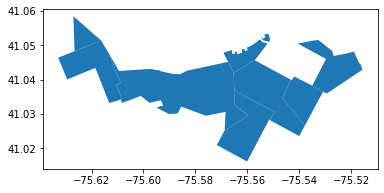

In [ ]:
# Plot weconservePA and fielddoc protected lands
wcpa_gdf = wcpa_gdf[wcpa_gdf.index > 2992]
x = wcpa_gdf[wcpa_gdf['sitename']=='State Game Land 129']
x.plot()

In [85]:
cluster_gdf = cluster_gdf.astype({'name': object, 'labels': object})
#cluster_gdf = cluster_gdf.reset_index()
cluster_gdf

,labels,gid,objectid,label_id,sum_acres,acres,ncontrb_a,acres_ans,name,shape_leng,shape_area,geom
0,Poconos and Kittatinny,1,0,5,8.662812e+05,8.662812e+05,8.655927e+05,865593,Poconos and Kittatinny,5.179372,0.368441,"MULTIPOLYGON (((-74.85664 41.72986, -74.85633 ..."
1,Middle Schuylkill,2,0,3,5.018739e+05,5.018739e+05,5.015325e+05,501533,Middle Schuylkill,0.000000,0.000000,"MULTIPOLYGON (((-76.20066 40.49200, -76.20078 ..."
2,Brandywine and Christina,3,0,1,3.605241e+05,3.605241e+05,3.602701e+05,360270,Brandywine and Christina,0.000000,0.000000,"MULTIPOLYGON (((-75.60052 40.05667, -75.59983 ..."
3,New Jersey Highlands,4,0,4,4.417943e+05,4.417943e+05,4.414416e+05,441442,New Jersey Highlands,0.000000,0.000000,"MULTIPOLYGON (((-75.16331 40.94820, -75.16154 ..."
4,Schuylkill Highlands,5,0,6,1.091863e+05,1.091863e+05,1.091078e+05,109108,Schuylkill Highlands,0.000000,0.000000,"MULTIPOLYGON (((-75.63777 40.25676, -75.63702 ..."
5,Upstream Suburban Philadelphia,6,0,8,8.465670e+04,8.465670e+04,8.458919e+04,84589,Upstream Suburban Philadelphia,0.000000,0.000000,"MULTIPOLYGON (((-75.24542 40.24569, -75.24462 ..."
6,Kirkwood - Cohansey Aquifer,7,0,2,1.355948e+06,1.355948e+06,1.354892e+06,1354892,Kirkwood Cohansey Aquifer,0.000000,0.000000,"MULTIPOLYGON (((-75.42338 39.55279, -75.42374 ..."
7,Upper Lehigh,8,0,7,4.894516e+05,4.894516e+05,4.890917e+05,489092,Upper Lehigh,0.000000,0.000000,"MULTIPOLYGON (((-75.41172 41.28605, -75.41113 ..."


<AxesSubplot:>

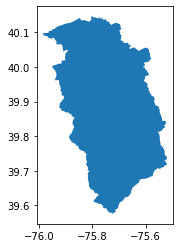

In [59]:
cluster_gdf.to_crs(epsg=4326, inplace=True)
x = cluster_gdf[cluster_gdf['name']=='Brandywine and Christina']
x.plot()

### Protected lands 3030 call

In [20]:
def get_3030_protected_lands(geojson):
    pl_3030_dict = {'OBJECTID':[],
                        'sitename': [],
                        'practice_type': [],
                        'mmw_area_m2': [],
                        'forest_area_m2': [],
                        'natural_area_m2': []}

    forest_lu = [41, 42, 43]

    # Include open water, forest, shrub/scrub, grassland/herbaceous, and wetlands as "natural"
    natural_lu = [11, 41, 42, 43, 52, 71, 90, 95]
    
    # Kent, DE 775; Sussex, DE 825; Haman 1031; Myrancuk 1746
    # Smith 2161; Tom 2327; Twp 2359; U-pick 2992
    # Error no objects to concatenate
    
    for item in geojson['features']:
        name = item['properties']['sitename']
        oid = item['properties']['OBJECTID']
        practice_type = item['properties']['RECLASS2']

        print(name)
        
        if (name != 'Arthur Weeks' and name != 'Caruso, Angelo J.' and name != 'Estate of George E. Scheller' 
            and name != 'Farm and Ranch Lands Protection Program (FRPP), Burlington, New Jersey' 
            and name != 'Farm And Ranch Lands Protection Program (Frpp), Kent, Delaware'
            and name != 'Farm And Ranch Lands Protection Program (Frpp), Sussex, Delaware'
            and name != 'Haman-Hoch-Coleman District' and name != 'Myrancuk & Weinroth'
            and name != 'Smith District' and name != 'Tom & Denise Costantino'
            and name != 'Twp of Blairstown (DeBlock)' and name != 'U-Pick Farm Stream Corridor'
            and name != 'Salem County, NJ 111'):

            item_lu_df = mmw_run.run_batch_analysis(
                [item['geometry']],
                mmw_run.land_endpoint.format("2019_2019"))

            total_area_m2 = item_lu_df['area'].sum()

            forest_df = item_lu_df[item_lu_df['nlcd'].isin(forest_lu)]
            forest_m2 = forest_df['area'].sum()

            natural_df = item_lu_df[item_lu_df['nlcd'].isin(natural_lu)]
            natural_m2 = natural_df['area'].sum()

            perc_forest = forest_m2/total_area_m2 * 100
            perc_natural = natural_m2/total_area_m2 * 100

            pl_3030_dict['sitename'].append(name)
            pl_3030_dict['practice_type'].append(practice_type)
            pl_3030_dict['mmw_area_m2'].append(total_area_m2)
            pl_3030_dict['forest_area_m2'].append(forest_m2)
            pl_3030_dict['natural_area_m2'].append(natural_m2)
            pl_3030_dict['OBJECTID'].append(oid)

            
    pl_3030_df = pd.DataFrame().from_dict(pl_3030_dict)
    return(pl_3030_df)

In [21]:
get_3030_protected_lands(wcpa_json)

Farm And Ranch Lands Protection Program (Frpp), Kent, Delaware
Salem County, NJ 111
SADC/Applegate


ValueError: No objects to concatenate

In [20]:
wcpa_lu

,sitename,practice_type,mmw_area_m2,perc_forest,perc_natural
0,A & A Likanchuk Enterprises,Agricultural Easement,188438.510607,29.047619,29.047619
1,A Massey And Mary G Moor Expansion Of The Mrs ...,Agricultural Easement,200108.761614,0.000000,8.520179
2,A. Robert & Elizabeth Masten Forestland Preser...,Agricultural Easement,62817.072814,11.428571,97.142857
3,A. Robert Masten District,Agricultural Easement,680216.036057,5.013193,42.875989


In [ ]:
fig, ax = plt.subplots()
wcpa_gdf.geometry.boundary.plot(color=None,edgecolor='k',ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots()
fielddoc_gdf.geometry.boundary.plot(color=None,edgecolor='k',ax=ax)
plt.show()

In [ ]:
for item in wcpa_json['features']:
    print(item['geometry'])

In [ ]:
wcpa_run_dict = {}

#fielddoc_run_dict[test['practice_name']] = {}
for item in wcpa_json['features']:
    

    print(f'Starting...')
    # Set up request
    DATA = {'area_of_interest': item['geometry']}
    HEADERS = {'Authorization': f'Token {MMW_API_TOKEN}'}
    res_base = requests.post(f'{MMW_API_URL}/analyze/land/2019/',data=DATA, headers=HEADERS)

    print('  waiting for id ... ')
    time.sleep(10)
    print(res_base.json())
    #PREPARE_JOB_UUID = res_base.json()['job_uuid']
    #res_base = requests.get(f'{MMW_API_URL}/jobs/{PREPARE_JOB_UUID}/', headers=HEADERS)
    #time.sleep(10)
    
    print('  sending run...')
    